# Shoreline extraction at the benchmark sites with CoastSat


This notebook shows how to extract time-series of shoreline change at the 4 benchmark sites using the CoastSat toolbox.

## Initial settings

Refer to the **Installation** section of the [CoastSat README](https://github.com/kvos/CoastSat) for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from scipy import interpolate
from scipy import stats
import pytz
import json 
# load coastsat package located under algorithms/COASTSAT/
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

# filepaths to all the datasets
fp_datasets = os.path.join(os.path.join(os.pardir,os.pardir,'datasets'))
names_datasets = os.listdir(fp_datasets)
names_datasets = [_ for _ in names_datasets if _ not in ['README.md','sites_info.txt']]
print('\nBenchmark datasets available:\n%s'%(names_datasets))
                
# load site info dict if exists or create
fp_info = os.path.join(fp_datasets,'sites_info.txt')
if os.path.exists(fp_info):
    with open(fp_info,'r') as f: sites_info = json.load(f)  
    print('\nLoaded sites_info.txt.')
else:
    sites_info = {'NARRABEEN':{'beach_slope':0.1,'contour_level':0.7,'epsg':28356},
                  'DUCK':{'beach_slope':0.1,'contour_level':0.585,'epsg':32119},
                  'TRUCVERT':{'beach_slope':0.05,'contour_level':1.5,'epsg':32630},
                  'TORREYPINES':{'beach_slope':0.045,'contour_level':0.792,'epsg':26946},
                 }
    with open(fp_info,'w') as f: json.dump(sites_info,f,indent=4)
for key in sites_info.keys(): print('%s: %s'%(key,sites_info[key]))


Benchmark datasets available:
['CALAMILLOR', 'DUCK', 'NARRABEEN', 'TORREYPINES', 'TRUCVERT']

Loaded sites_info.txt.
NARRABEEN: {'beach_slope': 0.1, 'contour_level': 0.7, 'epsg': 28356}
DUCK: {'beach_slope': 0.1, 'contour_level': 0.585, 'epsg': 32119}
TRUCVERT: {'beach_slope': 0.05, 'contour_level': 1.5, 'epsg': 32630}
TORREYPINES: {'beach_slope': 0.045, 'contour_level': 0.792, 'epsg': 26946}


## 1. Retrieval of the images from GEE for the test sites

Here we download all the Landsat (5,7,8,9) amd Sentinel-2 images between 1984 and 2022 for the benchmark sites using the provided ROIs.

In [2]:
# satellites to include
sat_list = ['L5','L7','L8']
# choose Landsat collection 'C01' or 'C02'
landsat_collection = 'C02'
# dates
dates = ['1984-01-01', '2022-01-01']
# folder to save the images in
fp_images = os.path.join(os.getcwd(),'satellite_data_C02')
# loop over each site
for sitename in names_datasets:
    print(sitename)
    data_folder = os.path.join(fp_datasets,sitename)
    # load polygon ROI
    fn_polygon = os.path.join(data_folder, '%s_polygon.geojson'%sitename)
    gdf_polygon = gpd.read_file(fn_polygon)
    polygon = np.array(gdf_polygon.loc[0,'geometry'].exterior.coords)
    # create inputs dictionary
    inputs = {}
    inputs['sitename'] = sitename
    inputs['polygon'] = [[[_[0], _[1]] for _ in polygon]]
    inputs['sat_list'] = sat_list
    inputs['dates'] = dates
    inputs['landsat_collection'] = landsat_collection
    inputs['filepath'] = fp_images
    if os.path.exists(os.path.join(fp_images,sitename,sitename+'_metadata.pkl')): 
        print('images already downloaded')
        continue
    # download the imagery
    metadata = SDS_download.retrieve_images(inputs)

CALAMILLOR
images already downloaded
DUCK
images already downloaded
NARRABEEN
images already downloaded
TORREYPINES
images already downloaded
TRUCVERT
images already downloaded


## 2. Extraction of shoreline time-series along the transects

In this cell we map the position of the shoreline on the satellite images, compute the intersections between the shorelines and the transects and perform a tidal correction.


Processing DUCK
Loaded reference shoreline in epsg:4326...converted to epsg:32119
loaded existing file at C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data_C02\DUCK\DUCK_output.pkl
Loaded transects in epsg:4326...converted to epsg:32119
Extracting closest points: 100%
Removing outliers...

Processing NARRABEEN
Loaded reference shoreline in epsg:4326...converted to epsg:28356
loaded existing file at C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data_C02\NARRABEEN\NARRABEEN_output.pkl
Loaded transects in epsg:4326...converted to epsg:28356
Extracting closest points: 100%
Removing outliers...

Processing TORREYPINES
Loaded reference shoreline in epsg:4326...converted to epsg:26946
loaded existing file at C:\Users\z5030440\Documents\SDS_Benchmark\algorithms\COASTSAT\satellite_data_C02\TORREYPINES\TORREYPINES_output.pkl
Loaded transects in epsg:4326...converted to epsg:26946
Extracting closest points: 100%
Removing outliers...
****
Proce

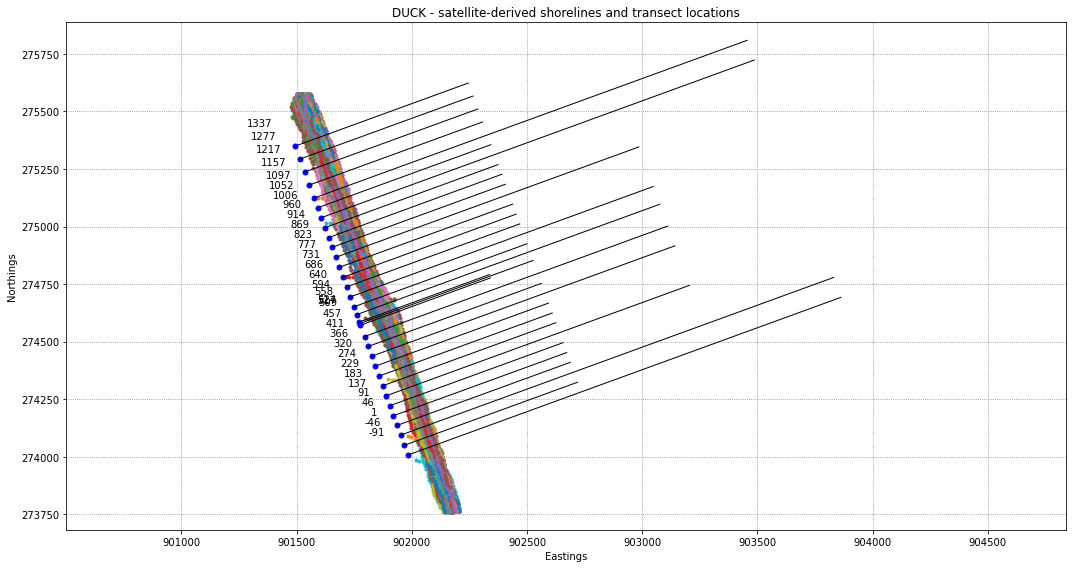

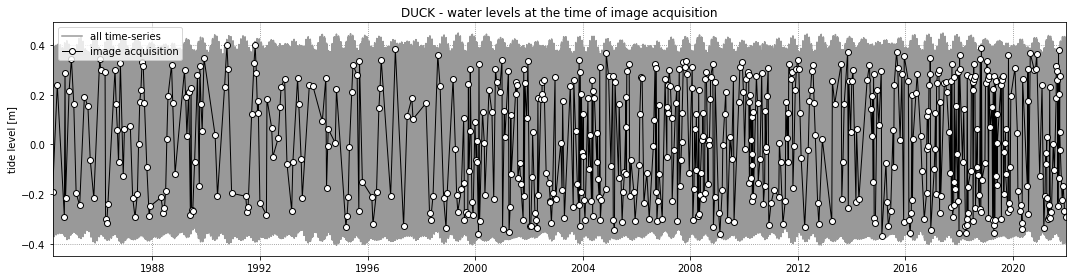

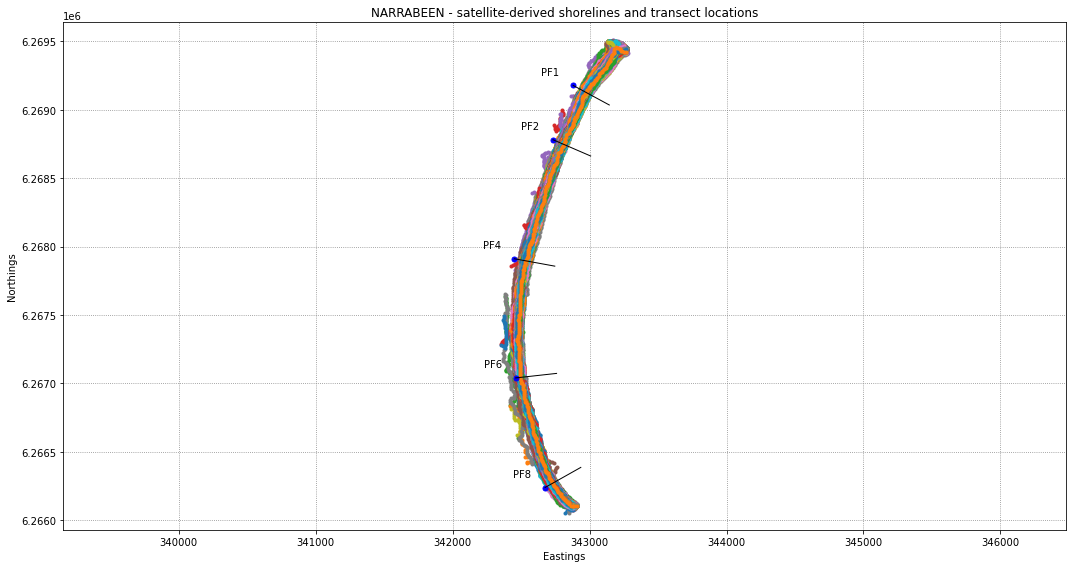

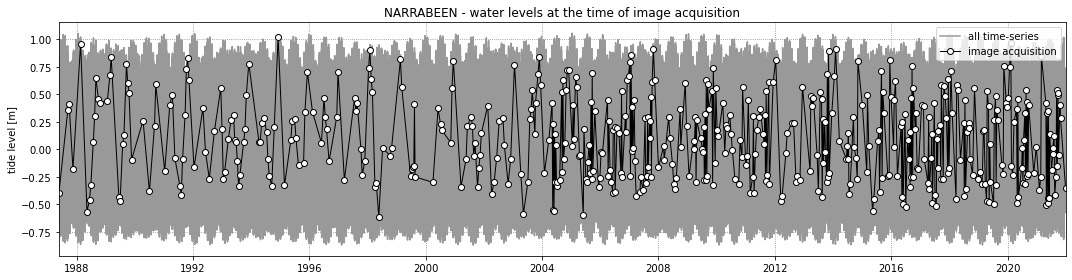

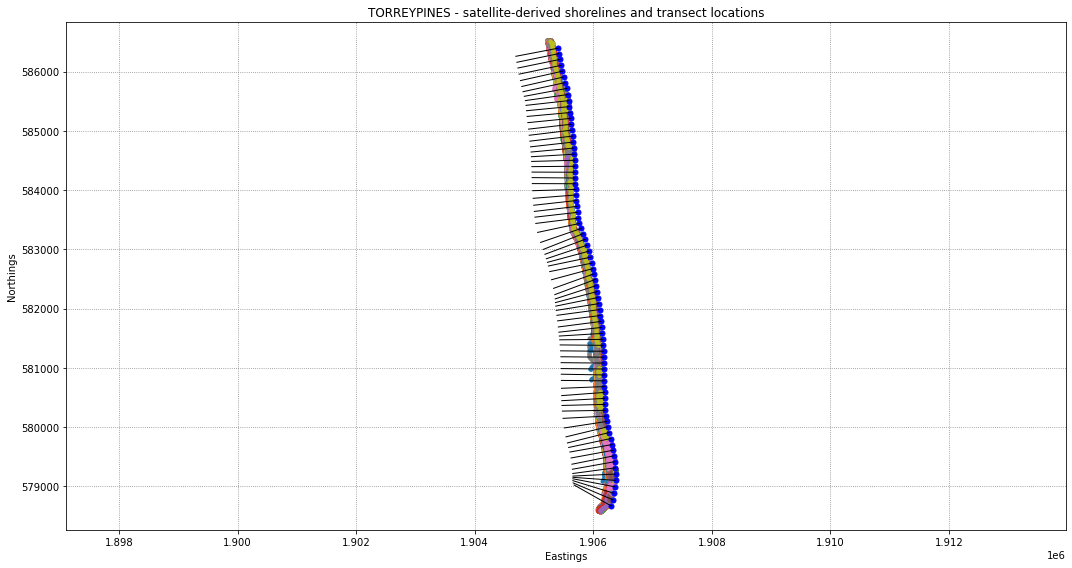

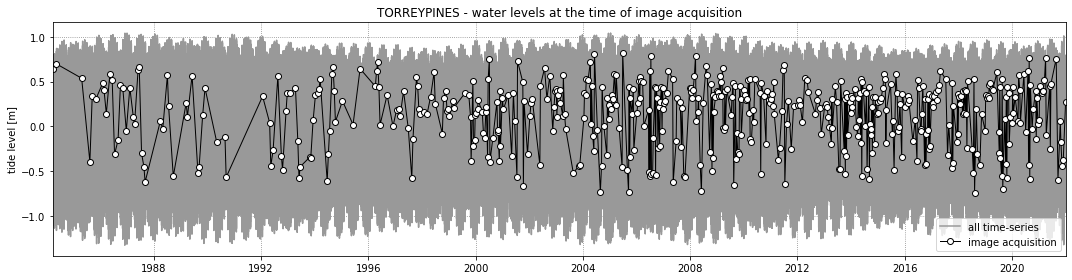

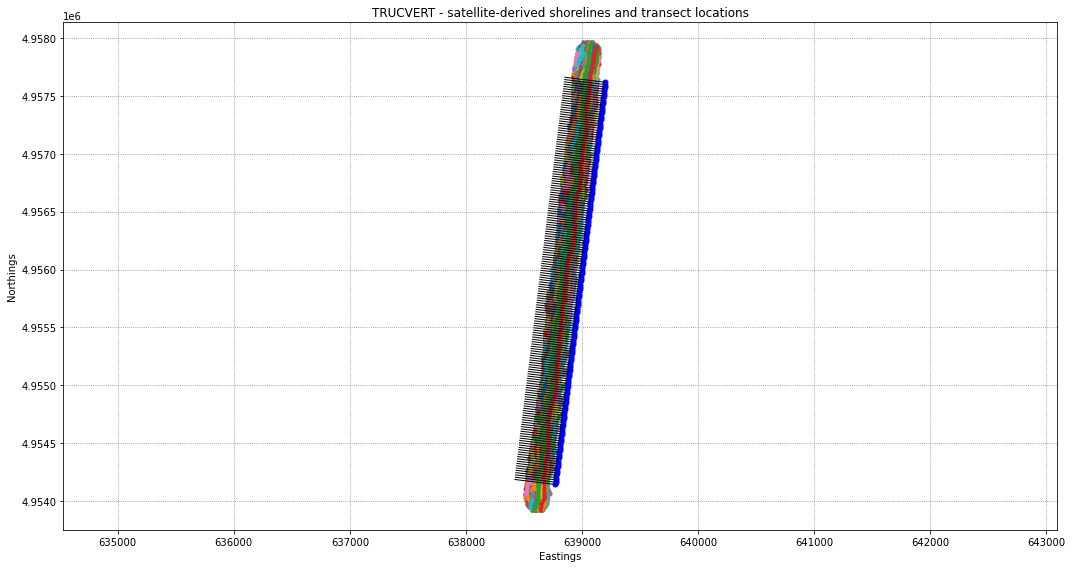

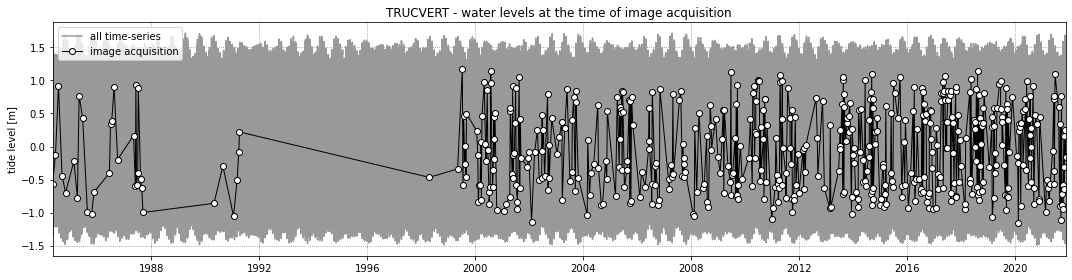

In [17]:
%matplotlib inline
# extract shoreline time-series at each site
inputs = {}
inputs['filepath'] =  os.path.join(os.getcwd(),'satellite_data_C02')
inputs['landsat_collection'] = 'C02'
inputs['dates'] =  ['1984-01-01', '2022-01-01']
inputs['sat_list'] = ['L5','L7','L8']
for sitename in names_datasets:
    if sitename == 'CALAMILLOR': continue    
    print('\nProcessing %s'%sitename)
    inputs['sitename'] = sitename
    #########################################################################################################
    # Map shorelines
    #########################################################################################################
    # load metadata
    metadata = SDS_download.get_metadata(inputs)
    # remove S2 in not in the inputs
    if ('S2' in metadata.keys()) and ('S2' not in inputs['sat_list']):  metadata.pop('S2');
    # load settings file
    fp_settings = 'settings_shoreline_mapping.txt'
    with open(fp_settings,'r') as f: settings = json.load(f)
    settings['inputs'] = inputs
    # take epsg from sites_info 
    settings['output_epsg'] = sites_info[sitename]['epsg']
    # load reference shoreline
    data_folder = os.path.join(fp_datasets,sitename)
    fn_refsl = os.path.join(data_folder, '%s_reference_shoreline.geojson'%sitename)
    gdf_refsl = gpd.read_file(fn_refsl)
    print('Loaded reference shoreline in epsg:%d'%gdf_refsl.crs.to_epsg(), end='...')
    gdf_refsl.to_crs(epsg=settings['output_epsg'], inplace=True)
    print('converted to epsg:%d'%gdf_refsl.crs.to_epsg())
    refsl = np.array(gdf_refsl.loc[0,'geometry'].coords)
    settings['reference_shoreline'] = refsl
    # extract shorelines from all images (creates or loads output.pkl)
    fn_output = os.path.join(inputs['filepath'], sitename, sitename + '_output' + '.pkl')
    if os.path.exists(fn_output):
        with open(fn_output, 'rb') as f:
            output = pickle.load(f)
        print('loaded existing file at %s'%fn_output)
    else:
        %matplotlib qt
        settings['save_figure'] = True
        output = SDS_shoreline.extract_shorelines(metadata, settings)
        # remove duplicates (images taken on the same date by the same satellite)
        output = SDS_tools.remove_duplicates(output)
        # remove inaccurate georeferencing (set threshold to 10 m)
        output = SDS_tools.remove_inaccurate_georef(output, 10)
        # remove bad images based on average classification (only works for same resolution, Landsat)
        if not 'S2' in metadata.keys():
            # settings for discarding the badly classified images"
            settings['prc_pixel'] = 0.15    # minimum percentage of change from land to water for defining the wet/dry areas
            settings['prc_image'] = 0.3     # maximum percentage of misclassified pixels allowed in the image, otherwise discarded
            output = SDS_shoreline.remove_bad_images(output,settings)
        else:
            output.pop('im_classif')
            with open(os.path.join(inputs['filepath'], inputs['sitename'], sitename + '_output' + '.pkl'), 'wb') as f:
                pickle.dump(output,f)
    # load transects
    fn_transects = os.path.join(data_folder, '%s_transects.geojson'%sitename)
    gdf_transects = gpd.read_file(fn_transects)
    print('Loaded transects in epsg:%d'%gdf_transects.crs.to_epsg(), end='...')
    gdf_transects.to_crs(epsg=settings['output_epsg'], inplace=True)
    print('converted to epsg:%d'%gdf_transects.crs.to_epsg())
    # put transects into a dictionary with their name
    transects = dict([])
    for i in gdf_transects.index:
        transects[gdf_transects.loc[i,'name']] = np.array(gdf_transects.loc[i,'geometry'].coords)
    fig,ax = plt.subplots(1,1,figsize=[15,8], tight_layout=True)
    ax.axis('equal')
    ax.set(xlabel='Eastings',ylabel='Northings',title='%s - satellite-derived shorelines and transect locations'%sitename)
    ax.grid(linestyle=':', color='0.5')
    for i in range(len(output['shorelines'])):
        sl = output['shorelines'][i]
        date = output['dates'][i]
        ax.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
    for i,key in enumerate(list(transects.keys())):
        ax.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
        ax.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
        if len(transects) < 50: ax.text(transects[key][0,0]-100, transects[key][0,1]+100, key,va='center', ha='right')
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'mapped_shorelines.jpg'),dpi=200)
    #########################################################################################################
    # Compute intersections
    #########################################################################################################
    # load settings file
    fp_settings = 'settings_transect_intersections.txt'
    with open(fp_settings,'r') as f: settings_transects = json.load(f)
    cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects)
    #########################################################################################################
    # Tidal correction
    #########################################################################################################
    # load tide time-series
    fn_tides = os.path.join(data_folder,'%s_tides.csv'%sitename)
    tide_data = pd.read_csv(fn_tides, parse_dates=['dates'])
    dates_ts = [pytz.utc.localize(_.to_pydatetime()) for _ in tide_data['dates']]
    tides_ts = np.array(tide_data['tides'])
    # get tide levels corresponding to the time of image acquisition
    dates_sat = output['dates']
    tides_sat = SDS_tools.get_closest_datapoint(dates_sat, dates_ts, tides_ts)
    # plot the subsampled tide data
    fig, ax = plt.subplots(1,1,figsize=(15,4), tight_layout=True)
    ax.grid(which='major', linestyle=':', color='0.5')
    ax.plot(tide_data['dates'], tide_data['tides'], '-', color='0.6', label='all time-series')
    ax.plot(dates_sat, tides_sat, '-o', color='k', ms=6, mfc='w',lw=1, label='image acquisition')
    ax.set(ylabel='tide level [m]',xlim=[dates_sat[0],dates_sat[-1]], title='%s - water levels at the time of image acquisition'%sitename)
    ax.legend()
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'], 'tide_timeseries.jpg'),dpi=200)
    # tidal correction along each transect
    reference_elevation = sites_info[sitename]['contour_level'] # elevation at which you would like the shoreline time-series to be
    beach_slope = sites_info[sitename]['beach_slope']
    cross_distance_tidally_corrected, tidal_corrections = {},{}
    for key in cross_distance.keys():
        correction = (tides_sat-reference_elevation)/beach_slope
        tidal_corrections[key] = correction
        cross_distance_tidally_corrected[key] = cross_distance[key] + correction
    if sitename == 'TRUCVERT':     # remove low tide images for TRUCVERT only (based on Castelle et al. 2021)
        for key in cross_distance_tidally_corrected.keys():
            for i in range(len(cross_distance_tidally_corrected[key])):
                if tides_sat[i] < 0.2: cross_distance_tidally_corrected[key][i] = np.nan
    # remove outliers
    print('\nRemoving outliers...')
    cross_distance_tidally_corrected = SDS_transects.reject_outliers(cross_distance_tidally_corrected,output,settings_transects)
    # save in .csv files
    fp_raw_timeseries = os.path.join(inputs['filepath'], inputs['sitename'], 'raw_timeseries')
    fp_tc_timeseries = os.path.join(inputs['filepath'], inputs['sitename'], 'tidally_corected_timeseries')
    if not os.path.exists(fp_raw_timeseries): os.makedirs(fp_raw_timeseries)
    if not os.path.exists(fp_tc_timeseries): os.makedirs(fp_tc_timeseries)
    for key in cross_distance_tidally_corrected.keys():
        out_dict = dict([])
        out_dict['dates'] = output['dates']
        out_dict[key] = cross_distance_tidally_corrected[key]
        out_dict['satname'] = output['satname']
        df = pd.DataFrame(out_dict)
        df.index=df['dates']
        df.pop('dates')
        # save tidally_corrected timeseries
        fn = os.path.join(fp_tc_timeseries,'%s_timeseries_tidally_corrected.csv'%key)
        df.to_csv(fn, sep=',')
        # save raw timeseries
        out_dict[key] = cross_distance_tidally_corrected[key] - tidal_corrections[key]
        df = pd.DataFrame(out_dict)
        df.index=df['dates']
        df.pop('dates')
        fn = os.path.join(fp_raw_timeseries,'%s_timeseries_raw.csv'%key)
        df.to_csv(fn, sep=',')
    # plot time-series
    fp_plots = os.path.join(inputs['filepath'], inputs['sitename'], 'plots')
    if not os.path.exists(fp_plots): os.makedirs(fp_plots)
    month_colors = plt.cm.get_cmap('tab20')
    for key in cross_distance_tidally_corrected.keys():
        chainage = cross_distance_tidally_corrected[key]
        # remove nans
        idx_nan = np.isnan(chainage)
        dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
        chainage = chainage[~idx_nan] 
        # compute shoreline monthly averages
        dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
        # plot monthly averages
        fig,ax=plt.subplots(1,1,figsize=[14,4],tight_layout=True)
        ax.grid(b=True,which='major', linestyle=':', color='0.5')
        ax.set_title('Time-series at %s'%key, x=0, ha='left')
        ax.set(ylabel='distance [m]')
        ax.plot(dates_nonan, chainage,'+', lw=1, color='k', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
        ax.plot(dates_month, chainage_month, '-', lw=2, color='k', mfc='w', ms=4, label='monthly-averaged')
        # for k,month in enumerate(dict_month.keys()):
        #     ax.plot(dict_month[month]['dates'], dict_month[month]['chainages'],
        #              'o', mec='k', color=month_colors(k), label=month,ms=5)
        ax.legend(loc='lower left',ncol=7,markerscale=1.5,frameon=True,edgecolor='k',columnspacing=1)
        fig.savefig(os.path.join(fp_plots,'%s_timeseries.jpg'%key),dpi=200)
        plt.close(fig)


Plot the time-series of shoreline change

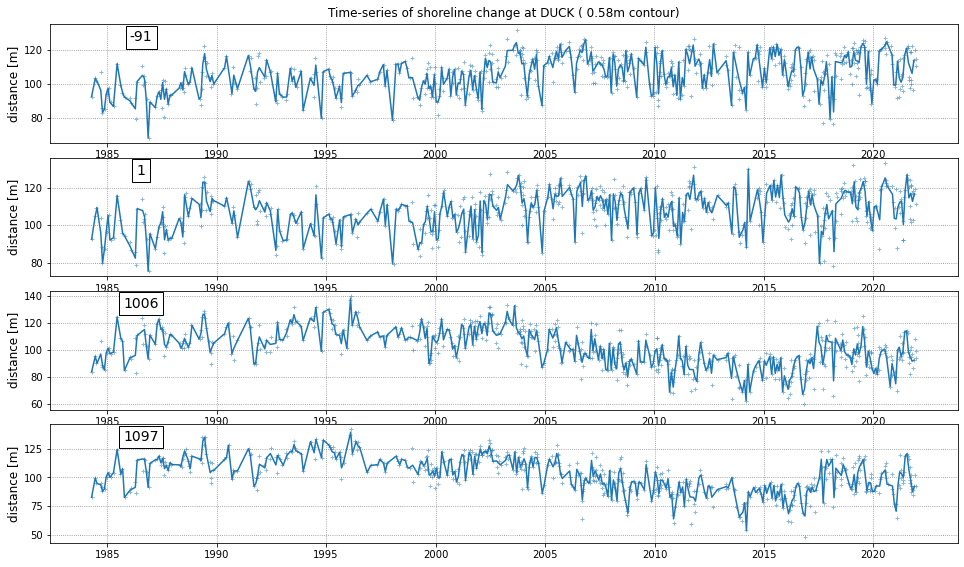

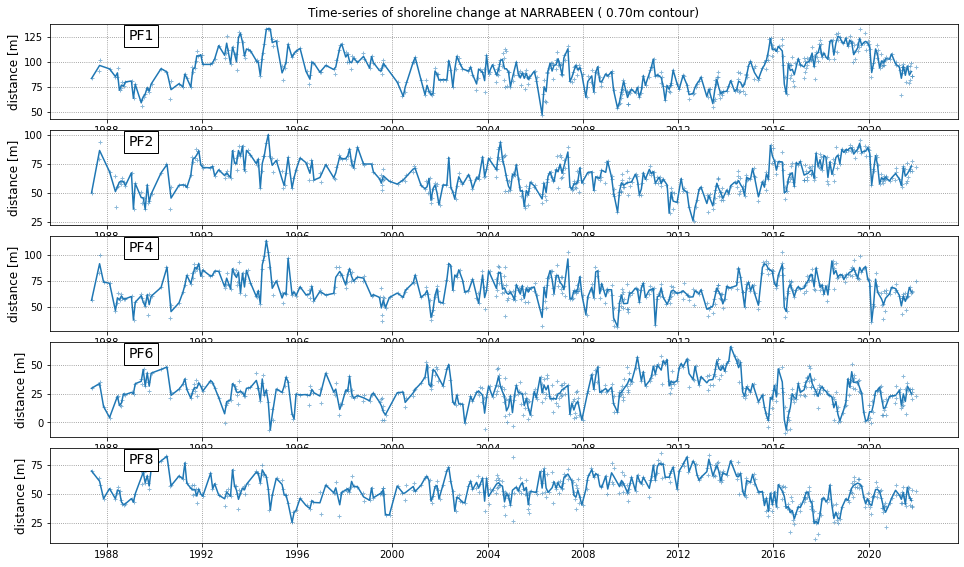

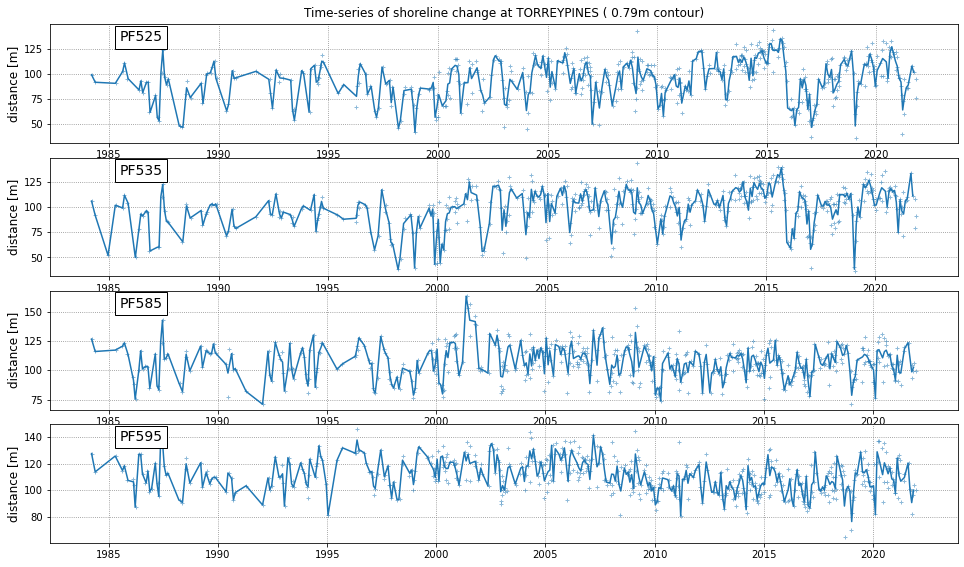

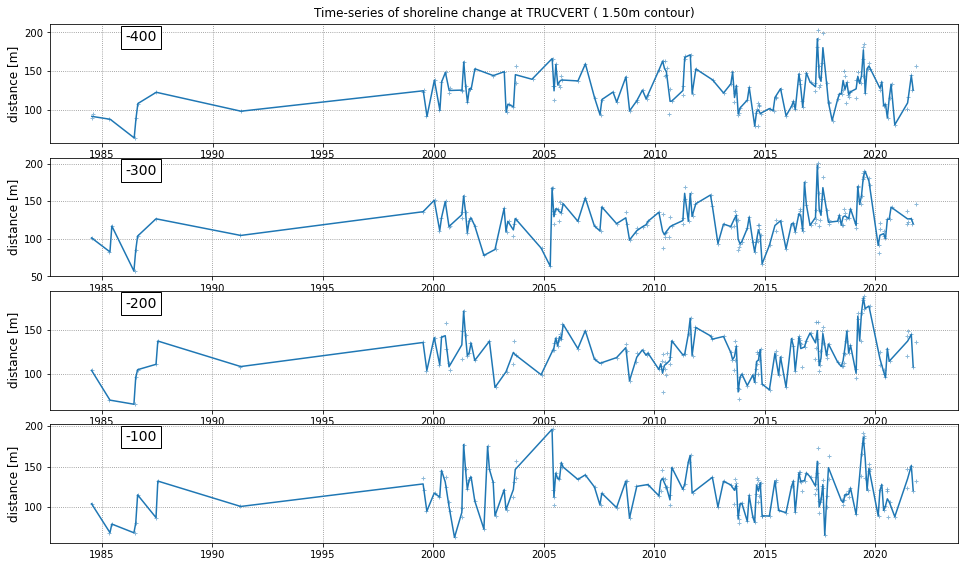

In [15]:
for sitename in names_datasets:
    if sitename == 'CALAMILLOR': continue 
    inputs['sitename'] = sitename
    # load time-series
    fp_tc_timeseries = os.path.join(inputs['filepath'], inputs['sitename'], 'tidally_corected_timeseries')
    fn_transects = os.listdir(fp_tc_timeseries)
    if sitename == 'DUCK': transects = ['-91','1','1006','1097']
    elif sitename == 'TRUCVERT': transects = ['-400','-300','-200','-100']
    elif sitename == 'TORREYPINES': transects =  ['PF525','PF535','PF585','PF595']
    elif sitename == 'NARRABEEN': transects = [_.split('_')[0] for _ in fn_transects]
    # make figure
    fig = plt.figure(figsize=[14,8], tight_layout=True)
    fig.suptitle('Time-series of shoreline change at %s ( %.2fm contour)'%(sitename,sites_info[sitename]['contour_level']))
    gs = gridspec.GridSpec(len(transects),1)
    gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.12)
    for i,key in enumerate(transects):
        fn = os.path.join(fp_tc_timeseries,'%s_timeseries_tidally_corrected.csv'%key)
        df = pd.read_csv(fn,sep=',',parse_dates=['dates'])  
        chainage = np.array(df[key])
        dates_sat = [_.to_pydatetime() for _ in df['dates']]
        # remove nans
        idx_nan = np.isnan(chainage)
        dates_nonan = [dates_sat[_] for _ in np.where(~idx_nan)[0]]
        chainage = chainage[~idx_nan]
        # compute shoreline monthly averages
        dict_month, dates_month, chainage_month, list_month = SDS_transects.monthly_average(dates_nonan, chainage)
        # plot time-series
        ax = fig.add_subplot(gs[i,0])
        ax.grid(b=True,linestyle=':', color='0.5')
        ax.plot(dates_nonan, chainage,'+', lw=1, color='C0', mfc='w', ms=4, alpha=0.5,label='raw datapoints')
        ax.plot(dates_month, chainage_month, '-', lw=1.5, color='C0', mfc='w', ms=4, label='monthly-averaged')
        ax.set_ylabel('distance [m]', fontsize=12)
        ax.text(0.1,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
                va='top', transform=ax.transAxes, fontsize=14)  
    fig.savefig(os.path.join(inputs['filepath'], inputs['sitename'],'%s_timeseries.jpg'%sitename), dpi=100);